Sentiment Classifier (Starter Code)
---

We will be creating a LogisticRegresion model with TF-IDF for sentiment classification. This notebook contains the required methods to read the data and create a pandas dataframe to start modeling.

Let's start by importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import csv

Reading the data from the respective CSV files. (Change the directory paths as needed).

In [3]:
#dev_datasets = Path("dev-datasets")
#test_datasets = Path("starting-kit-test")

def load_csv(path):
    with open(path, 'r') as f:
        reader = csv.reader(f)
        data = list(reader)
    return data

train_data = load_csv("train.csv")
dev_data = load_csv("dev.csv")
#test_data = load_csv(test_datasets / "test.csv")

# print number of rows and columns
print("Train data: ", len(train_data), len(train_data[0]))
print("Dev data: ", len(dev_data), len(dev_data[0]))
#print("Test data: ", len(test_data), len(test_data[0]))

# Convert to pandas dataframe
train_df = pd.DataFrame(train_data[1:], columns=train_data[0])
dev_df = pd.DataFrame(dev_data[1:], columns=dev_data[0])
#test_df = pd.DataFrame(test_data[1:], columns=test_data[0])

Train data:  92229 3
Dev data:  4856 2


We see that the dev and test data (when released). Don't have their labels. Hence all the modelling activity is done only on the train data.

So let's have a look at the training data

In [5]:
train_df.head()

,text_id,sentence,gold_label
0,r1-0051002,"Cheers,\n\nDennis Nguyen\n416-879-6431",0
1,r1-0020356,May have to wait longer on holidays.,-1
2,r1-0058348,"I drove to vegas may 6th, to get my hair done.",0
3,r1-0080006,"In addition, I eat out often at various restau...",1
4,r1-0000827,Perhaps she was doing us a favor?,0


## Data Analysis

This section is left blank but encourages you to do some data analysis on the training, dev and test data (if available). You can gain some interesting insights from the data and it can help in the modelling perspective.

Ideas:
- Label distribution (make a bar chart)
- NER extraction (maybe remove the entities to see if the accuracy is affected)
- Some unreadable characters or special characters (This can be removed as an attempt at data cleaning) (Regex is your best friend here)

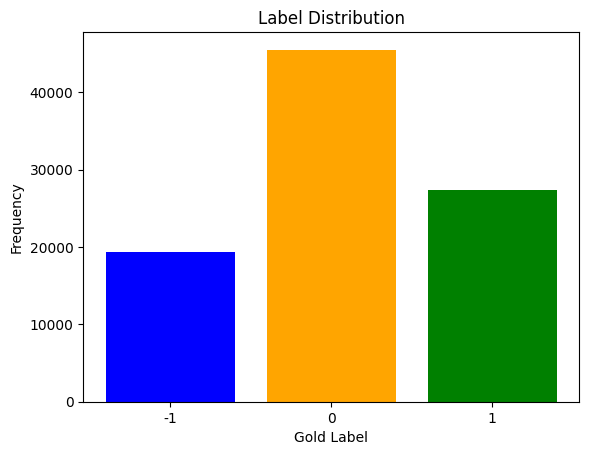

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy

# 1. Label Distribution
label_counts = train_df["gold_label"].value_counts().sort_index()
plt.bar(label_counts.index, label_counts.values, color=['blue', 'orange', 'green'])
plt.xlabel("Gold Label")
plt.ylabel("Frequency")
plt.title("Label Distribution")
plt.show()

In [8]:
# 2. Named Entity Recognition
nlp = spacy.load("en_core_web_sm")
ner_results = []
for sentence in train_df["sentence"]:
    doc = nlp(sentence)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    ner_results.append(entities)

train_df["entities"] = ner_results

In [12]:
# 3. Special Characters Analysis
train_df["special_chars"] = train_df["sentence"].apply(lambda x: re.findall(r"[^a-zA-Z0-9\s,.]", x))
train_df["cleaned_sentence"] = train_df["sentence"].apply(lambda x: re.sub(r"[^a-zA-Z0-9\s,.]", "", x))

train_df.head()

,text_id,sentence,gold_label,entities,special_chars,cleaned_sentence
0,r1-0051002,"Cheers,\n\nDennis Nguyen\n416-879-6431",0,"[(Dennis Nguyen, PERSON), (416, CARDINAL)]","[-, -]","Cheers,\n\nDennis Nguyen\n4168796431"
1,r1-0020356,May have to wait longer on holidays.,-1,[],[],May have to wait longer on holidays.
2,r1-0058348,"I drove to vegas may 6th, to get my hair done.",0,"[(6th, ORDINAL)]",[],"I drove to vegas may 6th, to get my hair done."
3,r1-0080006,"In addition, I eat out often at various restau...",1,"[(Cleveland, GPE), (Sanctuary, GPE)]",[],"In addition, I eat out often at various restau..."
4,r1-0000827,Perhaps she was doing us a favor?,0,[],[?],Perhaps she was doing us a favor


## Modelling

Creating a TF-IDF vectorizer as an input to a Logistic Regression model to classify the sentiments

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_Y = train_df["gold_label"]

# Create a TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(train_df["sentence"], train_Y)

train_X = vectorizer.transform(train_df["sentence"])

dev_X = vectorizer.transform(dev_df["sentence"])
#test_X = vectorizer.transform(test_df["sentence"])

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create a Logistic Regression model
model = LogisticRegression()
model.fit(train_X, train_Y)
train_score = model.score(train_X, train_Y)
print("Train accuracy: ", train_score)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy:  0.7254196122652556


A sample code to help in creating the `answer.txt` file required for submissions.

In [15]:
dev_predictions = model.predict(dev_X)
dev_df["predictions"] = dev_predictions

#test_predictions = model.predict(test_X)
#test_df["predictions"] = test_predictions

dev_df.to_csv("dev_predictions.csv", index=False)
#test_df.to_csv("test_predictions.csv", index=False)

In [16]:
def create_submission(df, filename):
    with open(filename, 'w') as f:
        for index, row in df.iterrows():
            f.write(row["predictions"] + "\n")

create_submission(dev_df, "answer.txt")
#create_submission(test_df, "test_answer.txt")